In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values

        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        counter = 0
        
        for epoch in range(epochs):

            self.discriminator.trainable = True
            
            if counter <500:
             # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)


                # Train the discriminator
                X = np.concatenate((imgs,gen_imgs))
                y = np.zeros([len(imgs)+len(gen_imgs),2])
                y[0:len(imgs),1] = 1
                y[len(imgs):,0] = 1
                d_loss = self.discriminator.train_on_batch(X, y)
            #             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
            #             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
            #             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            valid_y = np.zeros([batch_size,2])
            valid_y[:,1] = 1
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
            counter = counter + 1
            if counter > 1000:
                counter = 0
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1.3-losses.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))
        print(noise.shape)

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        print (gen_imgs.shape)
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1.3-v17-v10-img_2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        y_pred = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
        y_pred[np.where(y_pred>=cutt_off_tr)] = 1
        y_pred[np.where(y_pred<cutt_off_tr)]  = 0
        prfs = precision_recall_fscore_support(y_test, y_pred, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_pred, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_pred,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_pred))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_pred))
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()
    

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 147,714
Trainable params: 147,714
Non-trainable params: 0
_________________________________________________________________
____

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:205: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.691813, acc.: 54.69%] [G loss: 0.679294]
(492, 100)
(492, 30)
1 [D loss: 0.678332, acc.: 53.12%] [G loss: 0.645854]
2 [D loss: 0.672943, acc.: 50.00%] [G loss: 0.599151]
3 [D loss: 0.665476, acc.: 54.69%] [G loss: 0.567062]
4 [D loss: 0.678178, acc.: 48.44%] [G loss: 0.538964]
5 [D loss: 0.667516, acc.: 53.12%] [G loss: 0.504381]
6 [D loss: 0.674666, acc.: 51.56%] [G loss: 0.494934]
7 [D loss: 0.696016, acc.: 53.12%] [G loss: 0.488173]
8 [D loss: 0.719511, acc.: 45.31%] [G loss: 0.493410]
9 [D loss: 0.717723, acc.: 48.44%] [G loss: 0.494038]
10 [D loss: 0.727729, acc.: 51.56%] [G loss: 0.525556]
11 [D loss: 0.665786, acc.: 59.38%] [G loss: 0.553350]
12 [D loss: 0.665888, acc.: 59.38%] [G loss: 0.639607]
13 [D loss: 0.695078, acc.: 56.25%] [G loss: 0.664242]
14 [D loss: 0.728774, acc.: 50.00%] [G loss: 0.726119]
15 [D loss: 0.689178, acc.: 54.69%] [G loss: 0.781440]
16 [D loss: 0.643659, acc.: 59.38%] [G loss: 0.837703]
17 [D loss: 0.643858, acc.: 60.94%] [G loss: 0.890411]

147 [D loss: 0.622130, acc.: 79.69%] [G loss: 0.800138]
148 [D loss: 0.610096, acc.: 85.94%] [G loss: 0.810773]
149 [D loss: 0.624672, acc.: 82.81%] [G loss: 0.794765]
150 [D loss: 0.611739, acc.: 89.06%] [G loss: 0.814004]
151 [D loss: 0.637075, acc.: 79.69%] [G loss: 0.829453]
152 [D loss: 0.626794, acc.: 79.69%] [G loss: 0.805694]
153 [D loss: 0.606700, acc.: 87.50%] [G loss: 0.822386]
154 [D loss: 0.665808, acc.: 71.88%] [G loss: 0.817742]
155 [D loss: 0.636031, acc.: 73.44%] [G loss: 0.809576]
156 [D loss: 0.618029, acc.: 76.56%] [G loss: 0.825296]
157 [D loss: 0.599313, acc.: 85.94%] [G loss: 0.823511]
158 [D loss: 0.661574, acc.: 70.31%] [G loss: 0.831879]
159 [D loss: 0.656421, acc.: 68.75%] [G loss: 0.829338]
160 [D loss: 0.615857, acc.: 79.69%] [G loss: 0.835186]
161 [D loss: 0.616784, acc.: 79.69%] [G loss: 0.856284]
162 [D loss: 0.584982, acc.: 81.25%] [G loss: 0.870828]
163 [D loss: 0.650676, acc.: 60.94%] [G loss: 0.842969]
164 [D loss: 0.592175, acc.: 89.06%] [G loss: 0.

300 [D loss: 0.577201, acc.: 76.56%] [G loss: 0.832511]
301 [D loss: 0.547578, acc.: 84.38%] [G loss: 0.837088]
302 [D loss: 0.567250, acc.: 89.06%] [G loss: 0.843994]
303 [D loss: 0.591824, acc.: 82.81%] [G loss: 0.803133]
304 [D loss: 0.624576, acc.: 79.69%] [G loss: 0.816000]
305 [D loss: 0.572357, acc.: 73.44%] [G loss: 0.855317]
306 [D loss: 0.581214, acc.: 64.06%] [G loss: 0.847609]
307 [D loss: 0.569068, acc.: 79.69%] [G loss: 0.872230]
308 [D loss: 0.599552, acc.: 67.19%] [G loss: 0.850523]
309 [D loss: 0.580201, acc.: 78.12%] [G loss: 0.929554]
310 [D loss: 0.581524, acc.: 73.44%] [G loss: 0.935421]
311 [D loss: 0.650735, acc.: 60.94%] [G loss: 0.894540]
312 [D loss: 0.540785, acc.: 87.50%] [G loss: 0.887889]
313 [D loss: 0.550592, acc.: 92.19%] [G loss: 0.946545]
314 [D loss: 0.579631, acc.: 78.12%] [G loss: 0.948243]
315 [D loss: 0.527424, acc.: 81.25%] [G loss: 0.974268]
316 [D loss: 0.570608, acc.: 76.56%] [G loss: 0.960000]
317 [D loss: 0.515971, acc.: 85.94%] [G loss: 0.

447 [D loss: 0.608590, acc.: 64.06%] [G loss: 0.922405]
448 [D loss: 0.524148, acc.: 92.19%] [G loss: 0.890636]
449 [D loss: 0.557400, acc.: 75.00%] [G loss: 0.913769]
450 [D loss: 0.517323, acc.: 85.94%] [G loss: 0.908608]
451 [D loss: 0.553874, acc.: 89.06%] [G loss: 0.871065]
452 [D loss: 0.609670, acc.: 79.69%] [G loss: 0.901722]
453 [D loss: 0.531551, acc.: 85.94%] [G loss: 0.891041]
454 [D loss: 0.557161, acc.: 79.69%] [G loss: 0.861388]
455 [D loss: 0.583956, acc.: 75.00%] [G loss: 0.825300]
456 [D loss: 0.598233, acc.: 81.25%] [G loss: 0.872759]
457 [D loss: 0.571149, acc.: 85.94%] [G loss: 0.873158]
458 [D loss: 0.608697, acc.: 73.44%] [G loss: 0.885507]
459 [D loss: 0.555651, acc.: 82.81%] [G loss: 0.860542]
460 [D loss: 0.562771, acc.: 85.94%] [G loss: 0.889676]
461 [D loss: 0.504553, acc.: 79.69%] [G loss: 0.874428]
462 [D loss: 0.576300, acc.: 84.38%] [G loss: 0.866619]
463 [D loss: 0.529382, acc.: 89.06%] [G loss: 0.858820]
464 [D loss: 0.544265, acc.: 79.69%] [G loss: 0.

607 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.484338]
608 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.466862]
609 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.491501]
610 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.495121]
611 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.463223]
612 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.461386]
613 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.455611]
614 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.473460]
615 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.468361]
616 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.444624]
617 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.476789]
618 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.471130]
619 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.488898]
620 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.487353]
621 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.477048]
622 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.476864]
623 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.427640]
624 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.

756 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.380475]
757 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.370202]
758 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.377337]
759 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.353020]
760 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.358702]
761 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.366878]
762 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.357847]
763 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.353086]
764 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.375826]
765 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.367636]
766 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.347513]
767 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.341296]
768 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.342314]
769 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.389739]
770 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.361022]
771 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.377460]
772 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.364251]
773 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.

908 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.285846]
909 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.283837]
910 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.287532]
911 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.301864]
912 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.265560]
913 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.327774]
914 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.276332]
915 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.271719]
916 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.303872]
917 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.297751]
918 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.279408]
919 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.291864]
920 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.264055]
921 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.277000]
922 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.283841]
923 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.273934]
924 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.274174]
925 [D loss: 0.582831, acc.: 78.12%] [G loss: 0.

1053 [D loss: 0.586122, acc.: 75.00%] [G loss: 0.891208]
1054 [D loss: 0.548221, acc.: 75.00%] [G loss: 0.854544]
1055 [D loss: 0.766818, acc.: 50.00%] [G loss: 0.756464]
1056 [D loss: 0.526470, acc.: 78.12%] [G loss: 0.756676]
1057 [D loss: 0.721655, acc.: 59.38%] [G loss: 0.749277]
1058 [D loss: 0.585467, acc.: 64.06%] [G loss: 0.751303]
1059 [D loss: 0.630356, acc.: 65.62%] [G loss: 0.708196]
1060 [D loss: 0.639848, acc.: 59.38%] [G loss: 0.744643]
1061 [D loss: 0.552547, acc.: 73.44%] [G loss: 0.769455]
1062 [D loss: 0.656932, acc.: 59.38%] [G loss: 0.775628]
1063 [D loss: 0.636271, acc.: 54.69%] [G loss: 0.811046]
1064 [D loss: 0.654492, acc.: 60.94%] [G loss: 0.751925]
1065 [D loss: 0.620897, acc.: 57.81%] [G loss: 0.811956]
1066 [D loss: 0.699049, acc.: 46.88%] [G loss: 0.811224]
1067 [D loss: 0.646170, acc.: 51.56%] [G loss: 0.812226]
1068 [D loss: 0.644781, acc.: 65.62%] [G loss: 0.840419]
1069 [D loss: 0.699037, acc.: 59.38%] [G loss: 0.825412]
1070 [D loss: 0.631541, acc.: 7

1198 [D loss: 0.570819, acc.: 76.56%] [G loss: 0.817763]
1199 [D loss: 0.624932, acc.: 65.62%] [G loss: 0.873490]
1200 [D loss: 0.635776, acc.: 73.44%] [G loss: 0.872201]
1201 [D loss: 0.622148, acc.: 60.94%] [G loss: 0.889353]
1202 [D loss: 0.611309, acc.: 81.25%] [G loss: 0.836583]
1203 [D loss: 0.646232, acc.: 65.62%] [G loss: 0.821112]
1204 [D loss: 0.620975, acc.: 67.19%] [G loss: 0.842472]
1205 [D loss: 0.631231, acc.: 59.38%] [G loss: 0.825614]
1206 [D loss: 0.689817, acc.: 60.94%] [G loss: 0.800785]
1207 [D loss: 0.602258, acc.: 73.44%] [G loss: 0.777711]
1208 [D loss: 0.625073, acc.: 70.31%] [G loss: 0.793813]
1209 [D loss: 0.616657, acc.: 68.75%] [G loss: 0.783882]
1210 [D loss: 0.608756, acc.: 68.75%] [G loss: 0.808319]
1211 [D loss: 0.630613, acc.: 76.56%] [G loss: 0.798622]
1212 [D loss: 0.701725, acc.: 43.75%] [G loss: 0.788643]
1213 [D loss: 0.597939, acc.: 62.50%] [G loss: 0.792352]
1214 [D loss: 0.679372, acc.: 51.56%] [G loss: 0.795687]
1215 [D loss: 0.571841, acc.: 7

1349 [D loss: 0.580283, acc.: 70.31%] [G loss: 0.851252]
1350 [D loss: 0.660624, acc.: 59.38%] [G loss: 0.830704]
1351 [D loss: 0.702336, acc.: 43.75%] [G loss: 0.838217]
1352 [D loss: 0.660034, acc.: 67.19%] [G loss: 0.843772]
1353 [D loss: 0.627385, acc.: 59.38%] [G loss: 0.823580]
1354 [D loss: 0.559292, acc.: 71.88%] [G loss: 0.838650]
1355 [D loss: 0.631387, acc.: 62.50%] [G loss: 0.834293]
1356 [D loss: 0.614670, acc.: 64.06%] [G loss: 0.863528]
1357 [D loss: 0.631004, acc.: 65.62%] [G loss: 0.853091]
1358 [D loss: 0.631927, acc.: 70.31%] [G loss: 0.821167]
1359 [D loss: 0.601971, acc.: 76.56%] [G loss: 0.847790]
1360 [D loss: 0.608117, acc.: 71.88%] [G loss: 0.827405]
1361 [D loss: 0.650137, acc.: 64.06%] [G loss: 0.787202]
1362 [D loss: 0.611294, acc.: 60.94%] [G loss: 0.817026]
1363 [D loss: 0.645730, acc.: 65.62%] [G loss: 0.846285]
1364 [D loss: 0.641690, acc.: 68.75%] [G loss: 0.807302]
1365 [D loss: 0.590570, acc.: 68.75%] [G loss: 0.793627]
1366 [D loss: 0.581948, acc.: 6

1493 [D loss: 0.577736, acc.: 64.06%] [G loss: 0.902766]
1494 [D loss: 0.745730, acc.: 40.62%] [G loss: 0.858363]
1495 [D loss: 0.625388, acc.: 60.94%] [G loss: 0.898981]
1496 [D loss: 0.572130, acc.: 73.44%] [G loss: 0.886962]
1497 [D loss: 0.613302, acc.: 67.19%] [G loss: 0.920911]
1498 [D loss: 0.593900, acc.: 81.25%] [G loss: 0.888646]
1499 [D loss: 0.582995, acc.: 73.44%] [G loss: 0.898763]
1500 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.864795]
1501 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.892911]
1502 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.831673]
1503 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.825156]
1504 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.838800]
1505 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.825070]
1506 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.818636]
1507 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.795056]
1508 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.813577]
1509 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.770830]
1510 [D loss: 0.583084, acc.: 6

1645 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.148580]
1646 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.133493]
1647 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.153488]
1648 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.165458]
1649 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.155491]
1650 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.153584]
1651 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.146457]
1652 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.139252]
1653 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.106340]
1654 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.119189]
1655 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.144565]
1656 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.131846]
1657 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.155290]
1658 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.139361]
1659 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.106957]
1660 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.116865]
1661 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.134842]
1662 [D loss: 0.583084, acc.: 6

1801 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.060439]
1802 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.033879]
1803 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.051467]
1804 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.034485]
1805 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.024086]
1806 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.046406]
1807 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.051237]
1808 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.046480]
1809 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.036545]
1810 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.054078]
1811 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.032783]
1812 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.061034]
1813 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.020402]
1814 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.054434]
1815 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.044234]
1816 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.044490]
1817 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.051615]
1818 [D loss: 0.583084, acc.: 6

1946 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.027158]
1947 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.014816]
1948 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.021322]
1949 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.020429]
1950 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.024653]
1951 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.019722]
1952 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.023430]
1953 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.026886]
1954 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.017788]
1955 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.015842]
1956 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.019660]
1957 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.020275]
1958 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.032866]
1959 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.018653]
1960 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.019698]
1961 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.026977]
1962 [D loss: 0.583084, acc.: 68.75%] [G loss: 0.031793]
1963 [D loss: 0.583084, acc.: 6

2093 [D loss: 0.609362, acc.: 73.44%] [G loss: 0.702482]
2094 [D loss: 0.679737, acc.: 62.50%] [G loss: 0.773333]
2095 [D loss: 0.676550, acc.: 42.19%] [G loss: 0.734306]
2096 [D loss: 0.650305, acc.: 56.25%] [G loss: 0.683512]
2097 [D loss: 0.669344, acc.: 60.94%] [G loss: 0.681266]
2098 [D loss: 0.623027, acc.: 62.50%] [G loss: 0.758371]
2099 [D loss: 0.655155, acc.: 64.06%] [G loss: 0.766357]
2100 [D loss: 0.568289, acc.: 71.88%] [G loss: 0.892373]
2101 [D loss: 0.575092, acc.: 73.44%] [G loss: 1.021578]
2102 [D loss: 0.510444, acc.: 78.12%] [G loss: 0.934608]
2103 [D loss: 0.546812, acc.: 67.19%] [G loss: 0.786653]
2104 [D loss: 0.701568, acc.: 53.12%] [G loss: 0.688724]
2105 [D loss: 0.736770, acc.: 32.81%] [G loss: 0.746312]
2106 [D loss: 0.614656, acc.: 62.50%] [G loss: 0.770109]
2107 [D loss: 0.663192, acc.: 60.94%] [G loss: 0.787700]
2108 [D loss: 0.701773, acc.: 51.56%] [G loss: 0.803970]
2109 [D loss: 0.654473, acc.: 76.56%] [G loss: 0.843040]
2110 [D loss: 0.652328, acc.: 6

2238 [D loss: 0.609097, acc.: 79.69%] [G loss: 1.021226]
2239 [D loss: 0.632937, acc.: 64.06%] [G loss: 0.872119]
2240 [D loss: 0.632795, acc.: 65.62%] [G loss: 0.836770]
2241 [D loss: 0.694367, acc.: 62.50%] [G loss: 0.763046]
2242 [D loss: 0.701233, acc.: 71.88%] [G loss: 0.789009]
2243 [D loss: 0.703066, acc.: 57.81%] [G loss: 0.796143]
2244 [D loss: 0.647961, acc.: 68.75%] [G loss: 0.826635]
2245 [D loss: 0.712173, acc.: 71.88%] [G loss: 0.863126]
2246 [D loss: 0.554960, acc.: 90.62%] [G loss: 0.905368]
2247 [D loss: 0.583618, acc.: 70.31%] [G loss: 0.896897]
2248 [D loss: 0.629610, acc.: 78.12%] [G loss: 0.837943]
2249 [D loss: 0.545027, acc.: 75.00%] [G loss: 0.868706]
2250 [D loss: 0.601939, acc.: 68.75%] [G loss: 0.899844]
2251 [D loss: 0.590777, acc.: 73.44%] [G loss: 0.860299]
2252 [D loss: 0.607882, acc.: 64.06%] [G loss: 0.795627]
2253 [D loss: 0.543792, acc.: 82.81%] [G loss: 0.856683]
2254 [D loss: 0.571428, acc.: 81.25%] [G loss: 0.844832]
2255 [D loss: 0.563655, acc.: 7

2387 [D loss: 0.599528, acc.: 68.75%] [G loss: 0.829311]
2388 [D loss: 0.546072, acc.: 79.69%] [G loss: 0.850699]
2389 [D loss: 0.600215, acc.: 70.31%] [G loss: 0.875146]
2390 [D loss: 0.642868, acc.: 67.19%] [G loss: 0.883729]
2391 [D loss: 0.533266, acc.: 78.12%] [G loss: 0.854677]
2392 [D loss: 0.575725, acc.: 73.44%] [G loss: 0.858815]
2393 [D loss: 0.507928, acc.: 76.56%] [G loss: 0.852933]
2394 [D loss: 0.643790, acc.: 62.50%] [G loss: 0.890617]
2395 [D loss: 0.528932, acc.: 75.00%] [G loss: 0.864130]
2396 [D loss: 0.614833, acc.: 64.06%] [G loss: 0.826625]
2397 [D loss: 0.627476, acc.: 62.50%] [G loss: 0.764279]
2398 [D loss: 0.581407, acc.: 70.31%] [G loss: 0.731989]
2399 [D loss: 0.669291, acc.: 62.50%] [G loss: 0.736244]
2400 [D loss: 0.616545, acc.: 60.94%] [G loss: 0.761513]
2401 [D loss: 0.640955, acc.: 65.62%] [G loss: 0.783313]
2402 [D loss: 0.662727, acc.: 53.12%] [G loss: 0.848620]
2403 [D loss: 0.618240, acc.: 62.50%] [G loss: 0.902933]
2404 [D loss: 0.613185, acc.: 6

2538 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.429055]
2539 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.463304]
2540 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.448966]
2541 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.440898]
2542 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.444607]
2543 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.450742]
2544 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.453376]
2545 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.414625]
2546 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.401432]
2547 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.407475]
2548 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.419969]
2549 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.378286]
2550 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.429474]
2551 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.411223]
2552 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.437624]
2553 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.356689]
2554 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.370835]
2555 [D loss: 0.595924, acc.: 6

2687 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.125001]
2688 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.155048]
2689 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.132546]
2690 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.117457]
2691 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.135551]
2692 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.172713]
2693 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.109499]
2694 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.116111]
2695 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.127551]
2696 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.083714]
2697 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.128422]
2698 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.118244]
2699 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.141483]
2700 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.153366]
2701 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.082451]
2702 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.111612]
2703 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.095851]
2704 [D loss: 0.595924, acc.: 6

2835 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.053653]
2836 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.049514]
2837 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.075340]
2838 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.067981]
2839 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.045465]
2840 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.058786]
2841 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.074557]
2842 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.059899]
2843 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.041760]
2844 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.057329]
2845 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.064862]
2846 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.069952]
2847 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.084440]
2848 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.098686]
2849 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.037616]
2850 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.063882]
2851 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.056755]
2852 [D loss: 0.595924, acc.: 6

2985 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.054552]
2986 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.044948]
2987 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.047745]
2988 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.053212]
2989 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.051461]
2990 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.031709]
2991 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.024228]
2992 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.035058]
2993 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.048898]
2994 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.053688]
2995 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.038270]
2996 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.028890]
2997 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.044375]
2998 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.038625]
2999 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.030474]
3000 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.039617]
(492, 100)
(492, 30)
3001 [D loss: 0.595924, acc.: 64.06%] [G loss: 0.034184]
3002 [D lo

3136 [D loss: 0.594312, acc.: 76.56%] [G loss: 0.869224]
3137 [D loss: 0.646939, acc.: 64.06%] [G loss: 0.853986]
3138 [D loss: 0.620021, acc.: 64.06%] [G loss: 0.861159]
3139 [D loss: 0.627022, acc.: 67.19%] [G loss: 0.864255]
3140 [D loss: 0.619646, acc.: 71.88%] [G loss: 0.888343]
3141 [D loss: 0.544157, acc.: 79.69%] [G loss: 0.923950]
3142 [D loss: 0.608802, acc.: 64.06%] [G loss: 0.927793]
3143 [D loss: 0.581002, acc.: 68.75%] [G loss: 0.959803]
3144 [D loss: 0.625707, acc.: 60.94%] [G loss: 1.031208]
3145 [D loss: 0.516482, acc.: 75.00%] [G loss: 1.075424]
3146 [D loss: 0.607507, acc.: 68.75%] [G loss: 0.949214]
3147 [D loss: 0.612296, acc.: 73.44%] [G loss: 0.808933]
3148 [D loss: 0.578828, acc.: 71.88%] [G loss: 0.815920]
3149 [D loss: 0.596888, acc.: 68.75%] [G loss: 0.850351]
3150 [D loss: 0.521653, acc.: 76.56%] [G loss: 0.925230]
3151 [D loss: 0.558071, acc.: 71.88%] [G loss: 1.033046]
3152 [D loss: 0.549702, acc.: 71.88%] [G loss: 1.060154]
3153 [D loss: 0.539172, acc.: 8

3291 [D loss: 0.513520, acc.: 82.81%] [G loss: 0.975886]
3292 [D loss: 0.572942, acc.: 68.75%] [G loss: 0.918696]
3293 [D loss: 0.560967, acc.: 68.75%] [G loss: 0.939199]
3294 [D loss: 0.523365, acc.: 75.00%] [G loss: 0.871903]
3295 [D loss: 0.607021, acc.: 71.88%] [G loss: 0.904888]
3296 [D loss: 0.630608, acc.: 67.19%] [G loss: 0.840750]
3297 [D loss: 0.633540, acc.: 71.88%] [G loss: 0.802694]
3298 [D loss: 0.618495, acc.: 59.38%] [G loss: 0.838116]
3299 [D loss: 0.603892, acc.: 75.00%] [G loss: 0.818680]
3300 [D loss: 0.611910, acc.: 65.62%] [G loss: 0.831988]
3301 [D loss: 0.556424, acc.: 73.44%] [G loss: 0.850515]
3302 [D loss: 0.599853, acc.: 70.31%] [G loss: 0.866760]
3303 [D loss: 0.641592, acc.: 67.19%] [G loss: 0.904369]
3304 [D loss: 0.520863, acc.: 73.44%] [G loss: 0.833520]
3305 [D loss: 0.535642, acc.: 79.69%] [G loss: 0.866993]
3306 [D loss: 0.596136, acc.: 64.06%] [G loss: 0.883282]
3307 [D loss: 0.496925, acc.: 76.56%] [G loss: 0.923400]
3308 [D loss: 0.483650, acc.: 8

3443 [D loss: 0.582387, acc.: 67.19%] [G loss: 1.074133]
3444 [D loss: 0.510104, acc.: 79.69%] [G loss: 1.016351]
3445 [D loss: 0.556377, acc.: 81.25%] [G loss: 0.885653]
3446 [D loss: 0.551260, acc.: 75.00%] [G loss: 0.844292]
3447 [D loss: 0.642352, acc.: 62.50%] [G loss: 0.822152]
3448 [D loss: 0.591821, acc.: 75.00%] [G loss: 0.885975]
3449 [D loss: 0.545861, acc.: 81.25%] [G loss: 0.932665]
3450 [D loss: 0.553366, acc.: 76.56%] [G loss: 1.009842]
3451 [D loss: 0.512708, acc.: 79.69%] [G loss: 0.988806]
3452 [D loss: 0.551357, acc.: 67.19%] [G loss: 0.905867]
3453 [D loss: 0.548908, acc.: 79.69%] [G loss: 0.832579]
3454 [D loss: 0.624995, acc.: 54.69%] [G loss: 0.841416]
3455 [D loss: 0.608915, acc.: 64.06%] [G loss: 0.826800]
3456 [D loss: 0.620728, acc.: 64.06%] [G loss: 0.843004]
3457 [D loss: 0.630131, acc.: 60.94%] [G loss: 0.851812]
3458 [D loss: 0.615635, acc.: 64.06%] [G loss: 0.915174]
3459 [D loss: 0.517456, acc.: 79.69%] [G loss: 0.922844]
3460 [D loss: 0.540890, acc.: 6

3588 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.296081]
3589 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.321301]
3590 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.307157]
3591 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.254439]
3592 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.283942]
3593 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.321988]
3594 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.271901]
3595 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.292897]
3596 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.252214]
3597 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.290558]
3598 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.276396]
3599 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.305427]
3600 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.266771]
3601 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.305653]
3602 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.271217]
3603 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.266195]
3604 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.222117]
3605 [D loss: 0.581852, acc.: 7

3746 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.060916]
3747 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.100891]
3748 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.091480]
3749 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.085511]
3750 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.066102]
3751 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.080827]
3752 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.066843]
3753 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.077419]
3754 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.056478]
3755 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.083022]
3756 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.098605]
3757 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.066061]
3758 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.066017]
3759 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.074874]
3760 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.097529]
3761 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.076703]
3762 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.080145]
3763 [D loss: 0.581852, acc.: 7

3905 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.035408]
3906 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.037000]
3907 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.039301]
3908 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.047621]
3909 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.036273]
3910 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.058455]
3911 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.042330]
3912 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.039897]
3913 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.057708]
3914 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.032911]
3915 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.040436]
3916 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.040638]
3917 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.048871]
3918 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.031432]
3919 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.036892]
3920 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.037349]
3921 [D loss: 0.581852, acc.: 71.88%] [G loss: 0.039610]
3922 [D loss: 0.581852, acc.: 7

4058 [D loss: 0.380737, acc.: 93.75%] [G loss: 1.150755]
4059 [D loss: 0.426364, acc.: 89.06%] [G loss: 1.038308]
4060 [D loss: 0.458342, acc.: 90.62%] [G loss: 0.939066]
4061 [D loss: 0.791268, acc.: 81.25%] [G loss: 1.029352]
4062 [D loss: 0.578556, acc.: 71.88%] [G loss: 0.937549]
4063 [D loss: 0.504018, acc.: 78.12%] [G loss: 0.970475]
4064 [D loss: 0.467657, acc.: 78.12%] [G loss: 1.102131]
4065 [D loss: 0.473648, acc.: 75.00%] [G loss: 1.154602]
4066 [D loss: 0.502866, acc.: 75.00%] [G loss: 1.022958]
4067 [D loss: 0.640501, acc.: 87.50%] [G loss: 0.893836]
4068 [D loss: 0.561709, acc.: 78.12%] [G loss: 0.857972]
4069 [D loss: 0.608204, acc.: 65.62%] [G loss: 0.801561]
4070 [D loss: 0.484017, acc.: 84.38%] [G loss: 0.923657]
4071 [D loss: 0.568540, acc.: 81.25%] [G loss: 0.937646]
4072 [D loss: 0.576583, acc.: 67.19%] [G loss: 0.942243]
4073 [D loss: 0.527807, acc.: 75.00%] [G loss: 0.887067]
4074 [D loss: 0.657946, acc.: 65.62%] [G loss: 0.896610]
4075 [D loss: 0.507228, acc.: 7

4207 [D loss: 0.546889, acc.: 76.56%] [G loss: 0.987153]
4208 [D loss: 0.497806, acc.: 76.56%] [G loss: 0.997657]
4209 [D loss: 0.505221, acc.: 87.50%] [G loss: 1.046413]
4210 [D loss: 0.484572, acc.: 87.50%] [G loss: 1.104540]
4211 [D loss: 0.515327, acc.: 78.12%] [G loss: 1.131102]
4212 [D loss: 0.518058, acc.: 76.56%] [G loss: 0.985356]
4213 [D loss: 0.602731, acc.: 70.31%] [G loss: 0.973139]
4214 [D loss: 0.554901, acc.: 81.25%] [G loss: 0.879796]
4215 [D loss: 0.567797, acc.: 73.44%] [G loss: 0.937977]
4216 [D loss: 0.513607, acc.: 76.56%] [G loss: 0.903738]
4217 [D loss: 0.523564, acc.: 87.50%] [G loss: 0.937739]
4218 [D loss: 0.562780, acc.: 68.75%] [G loss: 0.995005]
4219 [D loss: 0.516138, acc.: 90.62%] [G loss: 0.949384]
4220 [D loss: 0.445698, acc.: 81.25%] [G loss: 1.058750]
4221 [D loss: 0.524083, acc.: 78.12%] [G loss: 1.047216]
4222 [D loss: 0.513520, acc.: 82.81%] [G loss: 1.041501]
4223 [D loss: 0.534003, acc.: 73.44%] [G loss: 1.035250]
4224 [D loss: 0.519526, acc.: 7

4350 [D loss: 0.512971, acc.: 78.12%] [G loss: 1.010030]
4351 [D loss: 0.629751, acc.: 57.81%] [G loss: 0.965835]
4352 [D loss: 0.609161, acc.: 73.44%] [G loss: 0.941397]
4353 [D loss: 0.631015, acc.: 57.81%] [G loss: 0.854657]
4354 [D loss: 0.620406, acc.: 67.19%] [G loss: 0.871053]
4355 [D loss: 0.473496, acc.: 79.69%] [G loss: 0.983367]
4356 [D loss: 0.555052, acc.: 60.94%] [G loss: 1.057539]
4357 [D loss: 0.424359, acc.: 82.81%] [G loss: 1.169909]
4358 [D loss: 0.425420, acc.: 85.94%] [G loss: 1.130718]
4359 [D loss: 0.598973, acc.: 70.31%] [G loss: 0.892912]
4360 [D loss: 0.573084, acc.: 73.44%] [G loss: 0.825817]
4361 [D loss: 0.430817, acc.: 84.38%] [G loss: 1.006346]
4362 [D loss: 0.496870, acc.: 78.12%] [G loss: 1.171293]
4363 [D loss: 0.503906, acc.: 79.69%] [G loss: 1.099331]
4364 [D loss: 0.560203, acc.: 76.56%] [G loss: 0.917247]
4365 [D loss: 0.496151, acc.: 79.69%] [G loss: 0.909541]
4366 [D loss: 0.606505, acc.: 68.75%] [G loss: 0.883792]
4367 [D loss: 0.584236, acc.: 6

4496 [D loss: 0.515475, acc.: 82.81%] [G loss: 0.967769]
4497 [D loss: 0.583322, acc.: 76.56%] [G loss: 0.835618]
4498 [D loss: 0.554092, acc.: 85.94%] [G loss: 0.893759]
4499 [D loss: 0.586102, acc.: 70.31%] [G loss: 0.917006]
4500 [D loss: 0.496584, acc.: 90.62%] [G loss: 0.964666]
4501 [D loss: 0.507801, acc.: 71.88%] [G loss: 1.055171]
4502 [D loss: 0.538440, acc.: 81.25%] [G loss: 1.064196]
4503 [D loss: 0.446869, acc.: 84.38%] [G loss: 1.057784]
4504 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.982522]
4505 [D loss: 0.446869, acc.: 84.38%] [G loss: 1.063010]
4506 [D loss: 0.446869, acc.: 84.38%] [G loss: 1.007880]
4507 [D loss: 0.446869, acc.: 84.38%] [G loss: 1.020437]
4508 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.955061]
4509 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.871832]
4510 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.878227]
4511 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.896456]
4512 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.857123]
4513 [D loss: 0.446869, acc.: 8

4646 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.192994]
4647 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.205221]
4648 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.180154]
4649 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.165366]
4650 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.172284]
4651 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.183607]
4652 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.184219]
4653 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.225507]
4654 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.140995]
4655 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.156006]
4656 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.156633]
4657 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.139731]
4658 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.177376]
4659 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.156057]
4660 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.188243]
4661 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.164146]
4662 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.166122]
4663 [D loss: 0.446869, acc.: 8

4799 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.122563]
4800 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.111825]
4801 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.090506]
4802 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.070020]
4803 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.098346]
4804 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.080544]
4805 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.097221]
4806 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.107962]
4807 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.109304]
4808 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.105222]
4809 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.109767]
4810 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.078265]
4811 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.107217]
4812 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.105538]
4813 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.104301]
4814 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.095910]
4815 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.078443]
4816 [D loss: 0.446869, acc.: 8

4950 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.077814]
4951 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.093283]
4952 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.093609]
4953 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.087872]
4954 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.072216]
4955 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.086751]
4956 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.079725]
4957 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.082781]
4958 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.083297]
4959 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.074372]
4960 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.076136]
4961 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.070869]
4962 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.045237]
4963 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.074125]
4964 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.076815]
4965 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.087711]
4966 [D loss: 0.446869, acc.: 84.38%] [G loss: 0.079083]
4967 [D loss: 0.446869, acc.: 8

5100 [D loss: 0.451709, acc.: 87.50%] [G loss: 0.947760]
5101 [D loss: 0.592771, acc.: 70.31%] [G loss: 0.876866]
5102 [D loss: 0.634446, acc.: 67.19%] [G loss: 0.918297]
5103 [D loss: 0.504674, acc.: 87.50%] [G loss: 0.890225]
5104 [D loss: 0.593959, acc.: 65.62%] [G loss: 0.880782]
5105 [D loss: 0.528296, acc.: 73.44%] [G loss: 0.866291]
5106 [D loss: 0.569422, acc.: 67.19%] [G loss: 0.849937]
5107 [D loss: 0.523846, acc.: 78.12%] [G loss: 0.858464]
5108 [D loss: 0.522393, acc.: 89.06%] [G loss: 0.816200]
5109 [D loss: 0.468766, acc.: 89.06%] [G loss: 0.811697]
5110 [D loss: 0.512340, acc.: 78.12%] [G loss: 0.947397]
5111 [D loss: 0.493135, acc.: 82.81%] [G loss: 1.025434]
5112 [D loss: 0.430168, acc.: 90.62%] [G loss: 1.128980]
5113 [D loss: 0.563388, acc.: 67.19%] [G loss: 0.949576]
5114 [D loss: 0.587542, acc.: 75.00%] [G loss: 0.813927]
5115 [D loss: 0.561227, acc.: 78.12%] [G loss: 0.864319]
5116 [D loss: 0.463321, acc.: 79.69%] [G loss: 0.856710]
5117 [D loss: 0.472202, acc.: 7

5249 [D loss: 0.493071, acc.: 89.06%] [G loss: 0.966286]
5250 [D loss: 0.559110, acc.: 75.00%] [G loss: 0.886570]
5251 [D loss: 0.534537, acc.: 78.12%] [G loss: 0.908761]
5252 [D loss: 0.544795, acc.: 75.00%] [G loss: 1.137878]
5253 [D loss: 0.524154, acc.: 82.81%] [G loss: 1.343190]
5254 [D loss: 0.455629, acc.: 81.25%] [G loss: 1.314064]
5255 [D loss: 0.428666, acc.: 84.38%] [G loss: 1.291731]
5256 [D loss: 0.516813, acc.: 79.69%] [G loss: 1.269899]
5257 [D loss: 0.471514, acc.: 87.50%] [G loss: 1.245931]
5258 [D loss: 0.404718, acc.: 89.06%] [G loss: 1.174627]
5259 [D loss: 0.513625, acc.: 76.56%] [G loss: 1.040689]
5260 [D loss: 0.573941, acc.: 82.81%] [G loss: 0.943217]
5261 [D loss: 0.530389, acc.: 79.69%] [G loss: 0.892446]
5262 [D loss: 0.495417, acc.: 75.00%] [G loss: 1.138829]
5263 [D loss: 0.476102, acc.: 82.81%] [G loss: 1.287112]
5264 [D loss: 0.479274, acc.: 87.50%] [G loss: 0.988993]
5265 [D loss: 0.553020, acc.: 70.31%] [G loss: 0.977440]
5266 [D loss: 0.492253, acc.: 7

5402 [D loss: 0.630643, acc.: 54.69%] [G loss: 0.853846]
5403 [D loss: 0.571278, acc.: 64.06%] [G loss: 0.903200]
5404 [D loss: 0.521530, acc.: 73.44%] [G loss: 0.914467]
5405 [D loss: 0.549622, acc.: 65.62%] [G loss: 1.066573]
5406 [D loss: 0.572713, acc.: 68.75%] [G loss: 1.113356]
5407 [D loss: 0.564851, acc.: 67.19%] [G loss: 0.996499]
5408 [D loss: 0.505268, acc.: 84.38%] [G loss: 0.899592]
5409 [D loss: 0.553018, acc.: 78.12%] [G loss: 0.896213]
5410 [D loss: 0.504120, acc.: 89.06%] [G loss: 0.965356]
5411 [D loss: 0.488491, acc.: 79.69%] [G loss: 1.040476]
5412 [D loss: 0.500132, acc.: 79.69%] [G loss: 0.938770]
5413 [D loss: 0.578844, acc.: 75.00%] [G loss: 0.946726]
5414 [D loss: 0.548503, acc.: 85.94%] [G loss: 1.042054]
5415 [D loss: 0.406095, acc.: 87.50%] [G loss: 1.178435]
5416 [D loss: 0.542394, acc.: 76.56%] [G loss: 0.952959]
5417 [D loss: 0.560889, acc.: 70.31%] [G loss: 0.862003]
5418 [D loss: 0.526723, acc.: 90.62%] [G loss: 0.973632]
5419 [D loss: 0.471312, acc.: 7

5552 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.542633]
5553 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.482253]
5554 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.487151]
5555 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.470256]
5556 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.500735]
5557 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.443038]
5558 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.534461]
5559 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.494440]
5560 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.481120]
5561 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.458990]
5562 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.451962]
5563 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.466134]
5564 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.444434]
5565 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.462757]
5566 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.439636]
5567 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.444952]
5568 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.465184]
5569 [D loss: 0.508546, acc.: 7

5701 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.238857]
5702 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.251150]
5703 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.259495]
5704 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.271932]
5705 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.252025]
5706 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.255815]
5707 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.271660]
5708 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.237436]
5709 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.227634]
5710 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.274563]
5711 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.242403]
5712 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.215434]
5713 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.289589]
5714 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.280539]
5715 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.261416]
5716 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.232766]
5717 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.241612]
5718 [D loss: 0.508546, acc.: 7

5860 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.186597]
5861 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.157864]
5862 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.181595]
5863 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.188706]
5864 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.216467]
5865 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.184734]
5866 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.181496]
5867 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.184794]
5868 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.216192]
5869 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.221266]
5870 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.161151]
5871 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.137483]
5872 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.179419]
5873 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.168162]
5874 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.205322]
5875 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.164911]
5876 [D loss: 0.508546, acc.: 79.69%] [G loss: 0.156438]
5877 [D loss: 0.508546, acc.: 7

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:312: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

<__main__.GAN instance at 0x162120320>

In [11]:
gan.losses

[([0.00044218861, 1.0], 1.9885263),
 ([0.00044218861, 1.0], 5.0112796),
 ([0.00044218861, 1.0], 4.5064564),
 ([0.00044218861, 1.0], 5.2146969),
 ([0.00044218861, 1.0], 5.3448334),
 ([0.00044218861, 1.0], 7.0132294),
 ([0.00044218861, 1.0], 7.4048252),
 ([0.00044218861, 1.0], 5.511447),
 ([0.00044218861, 1.0], 6.1891599),
 ([0.00044218861, 1.0], 6.0113478),
 ([0.00044218861, 1.0], 7.0132294),
 ([0.00044218861, 1.0], 5.5426869),
 ([0.00044218861, 1.0], 6.3654575),
 ([0.00044218861, 1.0], 6.3625994),
 ([0.00044218861, 1.0], 6.0113397),
 ([0.00044218861, 1.0], 6.3505526),
 ([0.00044218861, 1.0], 5.556664),
 ([0.00044218861, 1.0], 6.5664911),
 ([0.00044218861, 1.0], 5.0095286),
 ([0.00044218861, 1.0], 6.2178898),
 ([0.00044218861, 1.0], 6.0113935),
 ([0.00044218861, 1.0], 5.5109363),
 ([0.00044218861, 1.0], 5.5103951),
 ([0.00044218861, 1.0], 7.0134268),
 ([0.00044218861, 1.0], 5.3856149),
 ([0.00044218861, 1.0], 4.4114342),
 ([0.00044218861, 1.0], 5.7776155),
 ([0.00044218861, 1.0], 4.5085

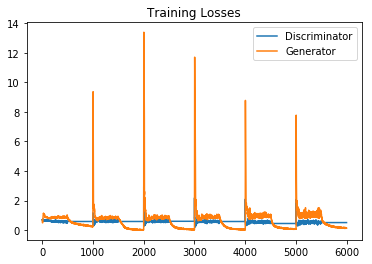

In [2]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

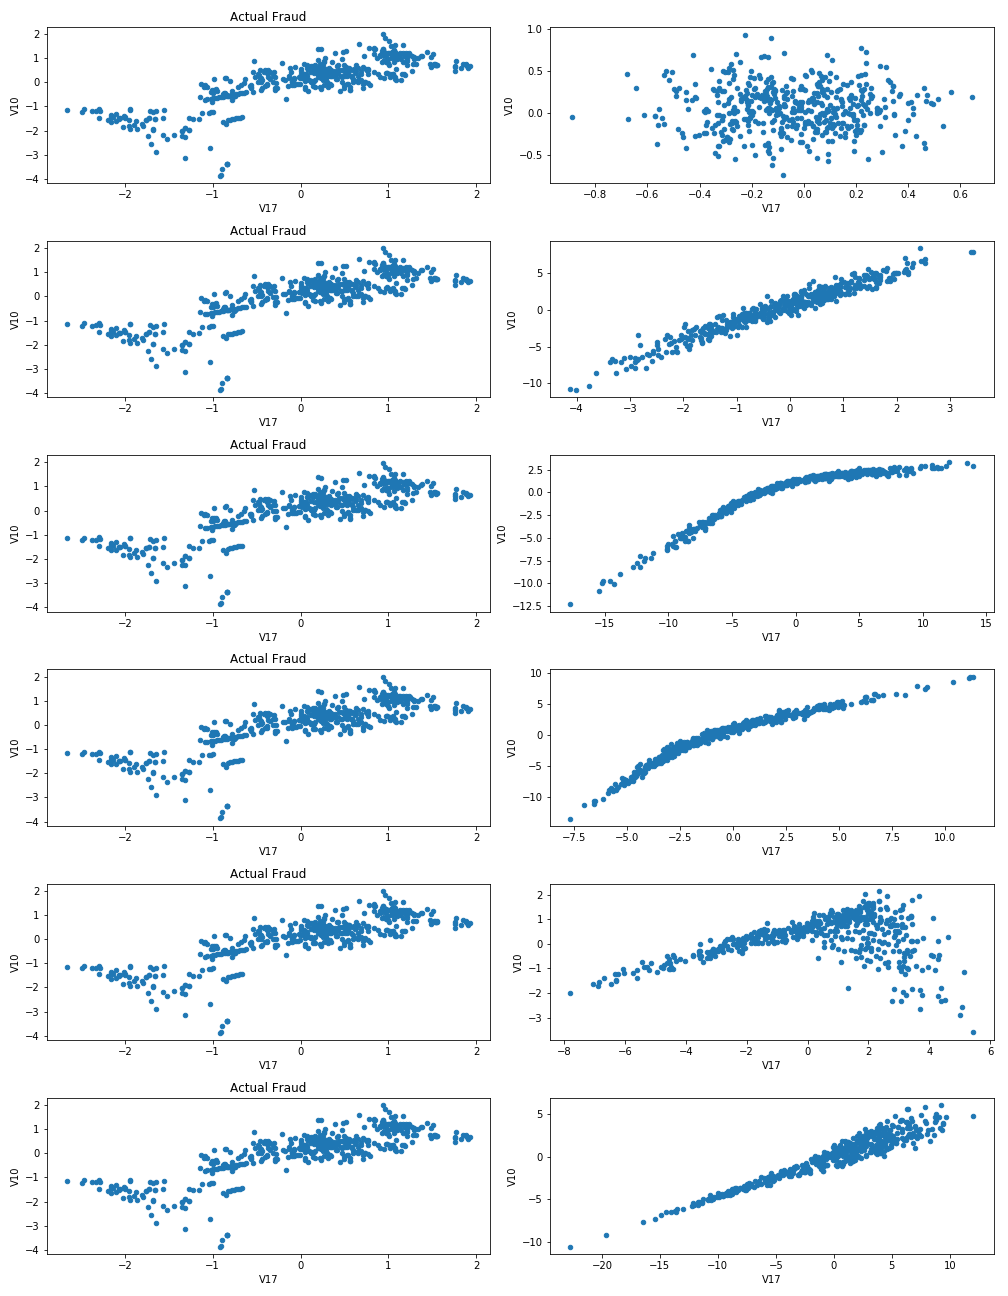

In [3]:
from IPython.display import Image
Image(filename='GANv1.3-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

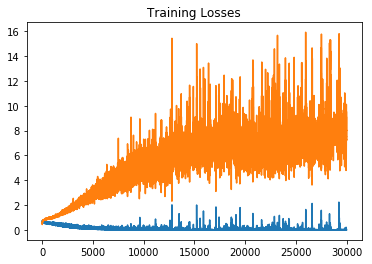

In [68]:
fig